# Lec 19 Lab: The Lasso
## CMSE 381 - Fall 2023
## Oct 18, 2023



In this module we are going to test out the lasso method, discussed in class.

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import make_pipeline



# Loading in the data

Ok, here we go, let's play with a baseball data set again. Note this cleanup is all the same as the last lab. 

In [2]:
hitters_df = pd.read_csv('../../DataSets/Hitters.csv')

# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df = hitters_df.dropna().drop('Player', axis=1)

# Replace any categorical variables with dummy variables
hitters_df = pd.get_dummies(hitters_df, drop_first = True)

hitters_df.head()

Dimensions of original data: (322, 21)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [3]:
y = hitters_df.Salary

# Drop the column with the independent variable (Salary)
X = hitters_df.drop(['Salary'], axis = 1).astype('float64')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    float64
 17  Division_W   263 non-null    float64
 18  NewLeague_N  263 non-null    float64
dtypes: float

Finally, here's a list of $\alpha$s to test for our Lasso.

In [4]:
# List of alphas
alphas = 10**np.linspace(4,-2,100)*0.5
alphas

array([5.00000000e+03, 4.34874501e+03, 3.78231664e+03, 3.28966612e+03,
       2.86118383e+03, 2.48851178e+03, 2.16438064e+03, 1.88246790e+03,
       1.63727458e+03, 1.42401793e+03, 1.23853818e+03, 1.07721735e+03,
       9.36908711e+02, 8.14875417e+02, 7.08737081e+02, 6.16423370e+02,
       5.36133611e+02, 4.66301673e+02, 4.05565415e+02, 3.52740116e+02,
       3.06795364e+02, 2.66834962e+02, 2.32079442e+02, 2.01850863e+02,
       1.75559587e+02, 1.52692775e+02, 1.32804389e+02, 1.15506485e+02,
       1.00461650e+02, 8.73764200e+01, 7.59955541e+01, 6.60970574e+01,
       5.74878498e+01, 5.00000000e+01, 4.34874501e+01, 3.78231664e+01,
       3.28966612e+01, 2.86118383e+01, 2.48851178e+01, 2.16438064e+01,
       1.88246790e+01, 1.63727458e+01, 1.42401793e+01, 1.23853818e+01,
       1.07721735e+01, 9.36908711e+00, 8.14875417e+00, 7.08737081e+00,
       6.16423370e+00, 5.36133611e+00, 4.66301673e+00, 4.05565415e+00,
       3.52740116e+00, 3.06795364e+00, 2.66834962e+00, 2.32079442e+00,
      

# Lasso 

Thanks to the wonders of `scikit-learn`, now that we know how to do all this with ridge regression, translation to lasso is super easy. 

- [Lasso Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- [LassoCV Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)
- [User guide](https://scikit-learn.org/stable/modules/linear_model.html#lasso)



In [5]:
from sklearn.linear_model import Lasso, LassoCV

Here's an example computing the lasso regression. 

In [7]:
a = 1 #<------ this is me picking an alpha value

# normalize the input
transformer = StandardScaler().fit(X)
# transformer.set_output(transform = 'pandas') #<---- some older versions of sklearn
                                               #      have issues with this
X_norm = pd.DataFrame(transformer.transform(X), columns = X.columns)

# Fit the regression
lasso = Lasso(alpha = a) 
lasso.fit(X_norm, y)

# Get all the coefficients
print('intercept:', lasso.intercept_)
print('\n')
print(pd.Series(lasso.coef_, index = X_norm.columns))
print('\nTraining MSE:',mean_squared_error(y,lasso.predict(X_norm)))

intercept: 535.9258821292775


AtBat         -281.117268
Hits           303.712775
HmRun           11.130509
Runs           -25.237507
RBI             -0.000000
Walks          120.835970
Years          -35.043287
CAtBat        -161.321987
CHits            0.000000
CHmRun          14.271823
CRuns          375.151758
CRBI           192.215411
CWalks        -190.239127
PutOuts         78.676450
Assists         41.885267
Errors         -18.834451
League_N        23.209008
Division_W     -58.234428
NewLeague_N     -4.941839
dtype: float64

Training MSE: 92609.01554579365


And the version using the `make_pipeline` along with the `StandardScaler` function which gives back the same answer.

In [8]:
a = 1#<------ this is me picking an alpha value


# The make_pipeline command takes care of the normalization and the 
# Lasso regression for you. Note that I am passing in the un-normalized
# matrix X everywhere in here, since the normalization happens internally.
model = make_pipeline(StandardScaler(), Lasso(alpha = a))
model.fit(X, y)
 
# Get all the coefficients. Notice that in order to get 
# them out of the ridge portion, we have to ask the pipeline 
# for the specific bit we want with the model.named_steps['ridge']
# in place of just ridge from above.
print('intercept:', model.named_steps['lasso'].intercept_)
print('\n')
print(pd.Series(model.named_steps['lasso'].coef_, index = X.columns))
print('\nTraining MSE:',mean_squared_error(y,model.predict(X)))

intercept: 535.9258821292775


AtBat         -281.117268
Hits           303.712775
HmRun           11.130509
Runs           -25.237507
RBI             -0.000000
Walks          120.835970
Years          -35.043287
CAtBat        -161.321987
CHits            0.000000
CHmRun          14.271823
CRuns          375.151758
CRBI           192.215411
CWalks        -190.239127
PutOuts         78.676450
Assists         41.885267
Errors         -18.834451
League_N        23.209008
Division_W     -58.234428
NewLeague_N     -4.941839
dtype: float64

Training MSE: 92609.01554579365


&#9989; **<font color=red>Do this:</font>** Mess with the values for $a$ in the code, such as for $a=1, 10, 100, 1000$. What do you notice about the coefficients? 

*Your answer here*


&#9989; **<font color=red>Do this:</font>** Make a graph of the coeffiencts from lasso as $\alpha$ changes 

*Note: we did similar things in the last class, I've included the code you can borrow and modify from there. Also note I got a bunch of convergence warnings, but drawing the graphs I could safely ignore them.*

In [9]:
# Your code for computing the coefficients goes here 
# I've included the code from last class that did this for the ridge version
# so you should just need to update it to do lasso instead.


coefs = []

for a in alphas:
    model = make_pipeline(StandardScaler(), Ridge(alpha = a))
    model.fit(X, y)
    coefs.append(model.named_steps['ridge'].coef_)
    

coefs = pd.DataFrame(coefs,columns = X_norm.columns)
coefs.head()
   

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
0,6.780624,7.846413,5.668981,7.382901,7.739614,7.908231,6.536754,8.894638,9.417447,8.959603,9.653524,9.732533,8.177650,5.941721,0.482213,-0.198173,0.147069,-4.066839,0.260218
1,7.482871,8.711141,6.222836,8.176418,8.547140,8.775630,7.167294,9.803256,10.402015,9.888785,10.662606,10.750886,8.995532,6.681835,0.538299,-0.238435,0.221313,-4.609158,0.332227
2,8.221672,9.637282,6.796229,9.020407,9.399342,9.703560,7.819084,10.758248,11.443720,10.869669,11.730158,11.828595,9.849605,7.497878,0.598915,-0.287508,0.315973,-5.215881,0.420140
3,8.991208,10.622778,7.382157,9.911172,10.290649,10.689638,8.484413,11.752906,12.537320,11.896678,12.850766,12.960326,10.732098,8.394523,0.664011,-0.347297,0.434733,-5.892882,0.526287
4,9.784056,11.664507,7.972138,10.843736,11.213981,11.730347,9.154123,12.779016,13.676264,12.962918,14.017662,14.139408,11.633564,9.376262,0.733471,-0.420043,0.581480,-6.646198,0.652960


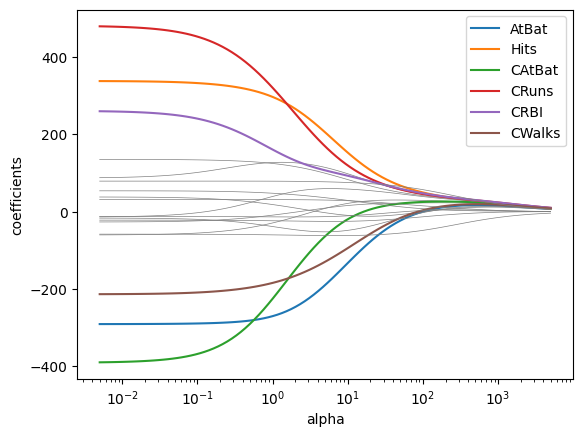

In [10]:
# If that worked above, you'll get a graph in this code. 

for var in coefs.columns:
    # I'm greying out the ones that have magnitude below 200 to easier visualization
    if np.abs(coefs[var][coefs.shape[0]-1])<200:
        plt.plot(alphas, coefs[var], color = 'grey', linewidth = .5)
    else:
        plt.plot(alphas, coefs[var], label = var)

plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')

plt.legend()

&#9989; **<font color=red>Do this:</font>** Make a graph the test mean squared error as $\alpha$ changes for a fixed train/test split. 

*Note: again I've included code from last time that you should just have to update.*

In [27]:
# Update this code to get the MSE for lasso instead of Ridge
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

errors = []
nonzero_coefs = []

for a in alphas:
    model = make_pipeline(StandardScaler(), Lasso(alpha = a))
    model.fit(X_train, y_train)
    nonzero_coefs.append(np.count_nonzero(model.named_steps['lasso'].coef_))
    pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, pred))


c:\Users\uzair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.873e+03, tolerance: 3.753e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\uzair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+04, tolerance: 3.753e+03
  model = cd_fast.enet_coordinate_descent(
c:\Users\uzair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Min occurs at alpha =  8.148754173103217
Min MSE is 115059.67295835954


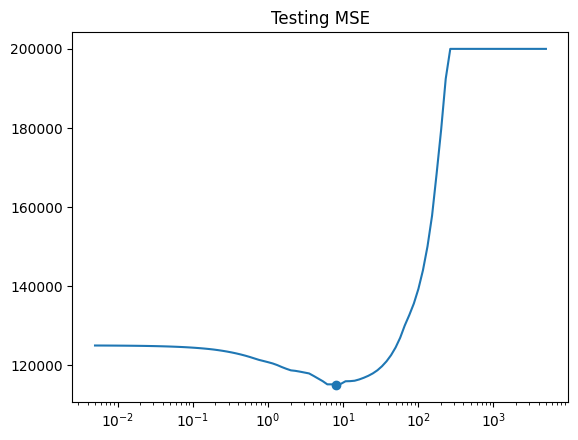

In [23]:
# If that worked, you should see your test error here.
i = np.argmin(errors) # Index of minimum 
print('Min occurs at alpha = ', alphas[i])
print('Min MSE is', errors[i])

plt.title('Testing MSE')
plt.plot(alphas,errors)
plt.scatter(alphas[i],errors[i])
ax=plt.gca()
ax.set_xscale('log')



&#9989; **<font color=red>Do this:</font>** make a plot showing the number of non-zero coefficients in each model.

*Hint: I used the `np.count_nonzero` command*

Text(0.5, 0, 'alpha')

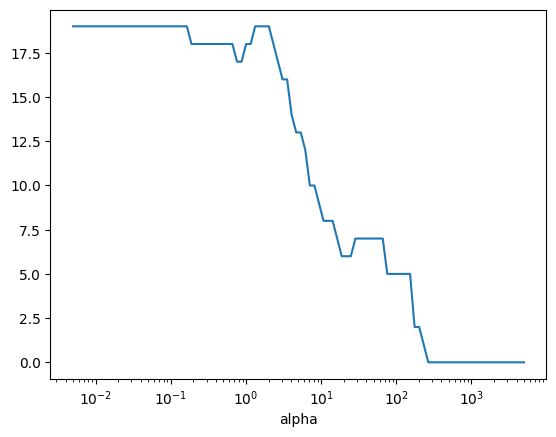

In [28]:
coefs

plt.plot(alphas,nonzero_coefs)
# log x axis
ax=plt.gca()
ax.set_xscale('log')
plt.xlabel('alpha')


# Your code here

&#9989; **<font color=red>Q:</font>** Say your goal was to end up with a model with 5 variables used. What choice of $\alpha$ gives us that and what are the variables used?  


In [39]:

# indexes where nonzero coefficients is 5

alphas[np.where(np.array(nonzero_coefs)==5)]

# one of these

array([152.69277544, 132.80438915, 115.506485  , 100.46165013,
        87.37642   ,  75.99555415])

In [ ]:
# Your code here 



## Lasso with Cross Validation

&#9989; **<font color=red>Do this:</font>** Now try what we did with `LassoCV`.  What choice of $\alpha$ does it recommend? 

*I would actually recommend either not passing in any $\alpha$ list or passing explicitly `alphas = None`. `RidgeCV` can't do this, but `LassoCV` will automatically try to find good choices of $\alpha$ for you.*

In [43]:
# Here's the ridge code from last time that you should update

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# To make sure my normalization isn't snooping, I fit the transformer only 
# on the training set 
transformer = StandardScaler().fit(X_train)
# transformer.set_output(transform = 'pandas')
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# but in order for my output results to make sense, I have to apply the same 
# transformation to the testing set. 
X_test_norm = transformer.transform(X_test)

# I'm going to drop that 0 from the alphas because it makes 
# RidgeCV cranky
alphas = alphas[:-1]


lassocv = LassoCV()
lassocv.fit(X_train_norm, y_train)

print('alpha chosen is', lassocv.alpha_)


alpha chosen is 1.0800619536094402


c:\Users\uzair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3967.876865901053, tolerance: 3280.1276823233893
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\uzair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4283.350349325687, tolerance: 3280.1276823233893
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\uzair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4426.633565645665, tolerance: 3280.1276823233893
  model = cd_fast.enet_coordinate_descent_gram(
c

In [ ]:
# Your code here

Now let's take a look at some of the coefficients. 

In [41]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lassocv.coef_, index=X.columns)

NameError: name 'lassocv' is not defined

&#9989; **<font color=red>Q:</font>** We've been repeating over and over that lasso gives us coefficients that are actually 0.  At least in my code, I'm not seeing many that are 0. What happened? Can I change something to get more 0 entries? 

*Your answer here*

In [ ]:
# You might also want some code in here to try to figure it out



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.